In [1]:
# Import some libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Import the dataset
# For a local installation where the file is in the same folder as this file
#df = pd.read_csv("Bitcoin_BTCUSDT.csv")
# For kaggle, if the dataset (which wasn't made by me) is added
df = pd.read_csv("/kaggle/input/bitcoin-btcusdt/Bitcoin_BTCUSDT.csv")
df.head()

,timestamp,open,high,low,close,volume
0,2018-01-01 00:01:00,13707.91,13707.91,13666.11,13694.92,2.113
1,2018-01-01 00:02:00,13682.00,13694.94,13680.00,13680.00,1.347
2,2018-01-01 00:03:00,13679.98,13679.98,13601.00,13645.99,11.586
3,2018-01-01 00:04:00,13645.98,13646.00,13576.28,13600.00,15.730
4,2018-01-01 00:05:00,13600.00,13600.00,13554.44,13568.00,6.395


## Set up a subset of the model
Create a subset of the data, which will be used to train the model multiple times to find the correct parameters

A size of 1000 has been chosen to hopefully show as much data as needed to make an initial prediction while keeping the sample size small, allowing it to be trained may times

In [3]:
# Generate y values - the thing we're trying to predict
y = df["open"].iloc[:1000]

# Generate x values. Make these numbers from 0 to len(y)
#x = []
#for i in range(0, len(y)):
    #x.append(str(i))

# Create our dataframe
data_shortened = pd.DataFrame()
print (len(y))
#print (len(x))
#data_shortened["x"] = x
data_shortened["y"] = y
data_shortened.head()

1000


,y
0,13707.91
1,13682.00
2,13679.98
3,13645.98
4,13600.00


<AxesSubplot:>

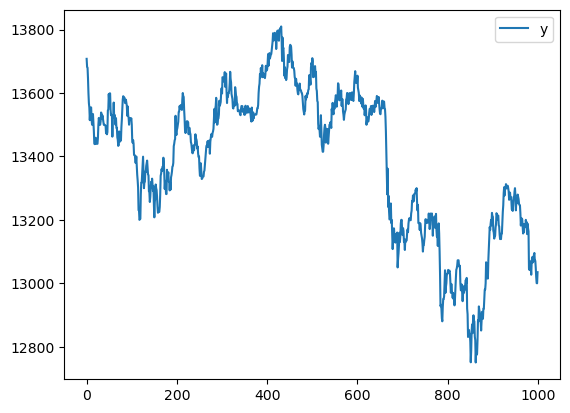

In [4]:
data_shortened.plot()

In [5]:
# Now we can do a test/train split

# Let's say 5% of the data is the test set
test_percent = 0.05

# Get the number of entries we want from the data_shortened dataset
test_point = np.round(len(data_shortened) * test_percent)

# Find the point to split off at
test_ind = int(len(data_shortened)-test_point)

# Define the test and train datasets
train_shortened = data_shortened.iloc[:test_ind]
test_shortened = data_shortened.iloc[test_ind:]

In [6]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

# Choose the scaler
scaler = MinMaxScaler()

# Scale the data
scaler.fit(train_shortened)
scaled_shortened_train = scaler.transform(train_shortened)
scaled_shortened_test = scaler.transform(test_shortened)

In [7]:
# Create batches for training
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Define characteristics
length = 49
batch_size = 4

# Create generator
generator = TimeseriesGenerator(scaled_shortened_train, scaled_shortened_train, length=length, batch_size=batch_size)
# Create validation generator
validation_generator = TimeseriesGenerator(scaled_shortened_test, scaled_shortened_test, length=length, batch_size=batch_size)

## Train the initial model

Next, we need to create and train the initial shortened model

In [8]:
# Create the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM

# Model feature
n_features = 1

# Define model
model = Sequential()
model.add(LSTM(50, input_shape=(length, n_features)))
# Output size and type
model.add(Dense(1))

# Compile
model.compile(optimizer="adam", loss="mse")

2023-02-21 22:36:18.156025: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-02-21 22:36:18.156082: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
# Check if the details are correct
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Setup callbacks
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=2)

In [11]:
# Train the model
model.fit_generator(generator, epochs=1, validation_data=validation_generator, callbacks=[early_stop])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


226/226 [==============================] - 8s 23ms/step - loss: 0.0152 - val_loss: 0.0011


## Evaluate the shortened model

Now, I need to evaluate this shortened model and make any changes as required

<AxesSubplot:>

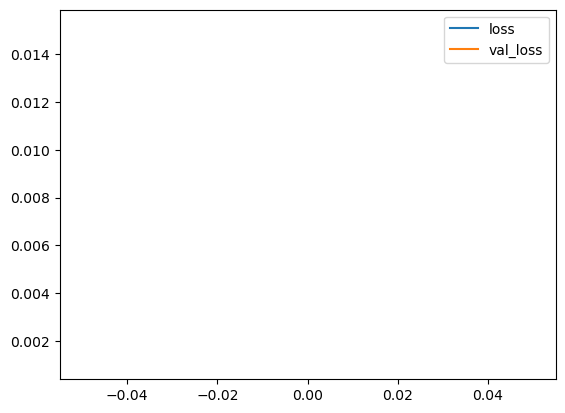

In [12]:
# Check out the losses
losses = pd.DataFrame(model.history.history)
losses.plot()

From this, there is a little overfitting, so adding a callback would help

In [13]:
# Evaluate on test data

# Get the scaled training data. Remove the last length values so we can evaluate it
first_eval_batch = scaled_shortened_train[-length:]

# Reshape it to the shape that teh model expects
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

# Predict
model.predict(first_eval_batch)

1/1 [==============================] - 0s 478ms/step


array([[0.4951951]], dtype=float32)

In [14]:
# Initialise values
test_predictions = []
first_eval_batch = scaled_shortened_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
print (len(first_eval_batch))
print (len(current_batch))

# Make a for look the keeps appending the predictions
# predict value, add to array, move the historical values array by one place
for i in range(len(test_shortened)) :
    # Get the current predictions
    current_pred = model.predict(current_batch)[0]
    # Append it to the list
    test_predictions.append(current_pred)
    # Move the current batch along by one timestamp, and add current pred at the end
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

49
1
1/1 [==============================] - 0s 22ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<AxesSubplot:>

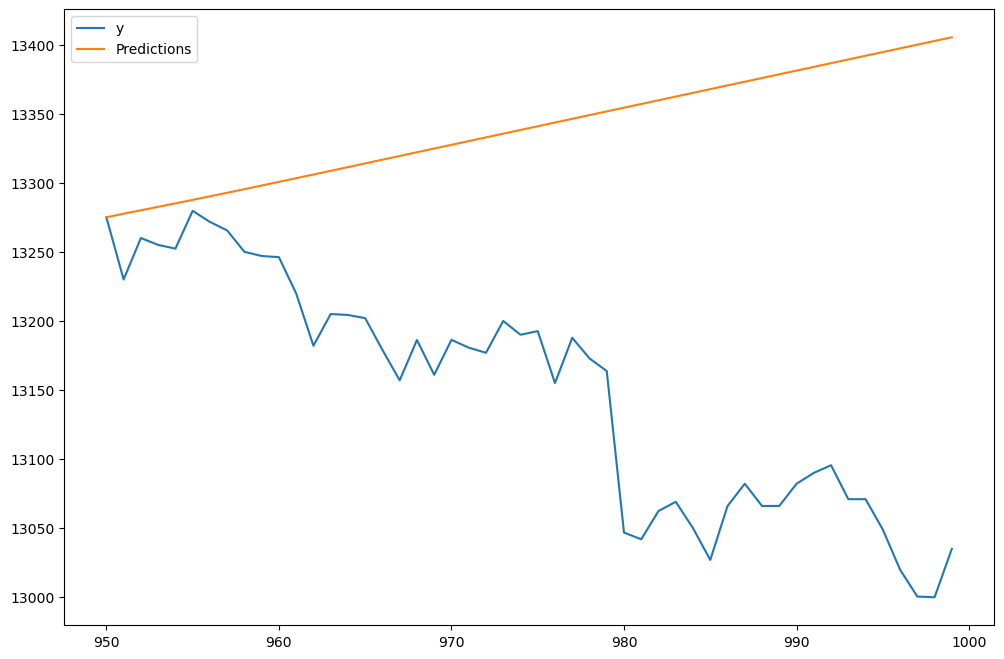

In [15]:
# Inverse transformation of predictions
true_predictions = scaler.inverse_transform(test_predictions)
# Add the test predictions to the test df
test_shortened["Predictions"] = true_predictions

# Plot the predictions along with the true values
test_shortened.plot(figsize=(12,8))

The initial attempt was horrible. It didn't even follow the broad trend. I increased the length and batch size, and it was a bit better. I did the following steps:
* Increase training set size
* Incorporate call backs
* Implement LTSM instead of SimpleRNN

Now,the training data was different, but less good - it was undercutting the true data significantly. Decreasing the training data size and increasing layer size did not help. I set the layer size back to 50.

## New Plan
After tweaking lots of things, my results still are really bad. Therefore, I'll try a new tactic. I'll get the average of 10 data values and combine it into a single value. Hopefully the data will vary less and show main trends, which will be easier to predict.

In [16]:
# Generate values as before
# Generate y values - the thing we're trying to predict
y = df["open"].iloc[:1000]

# Create our dataframe
data_shortened = pd.DataFrame()
print (len(y))
#print (len(x))
#data_shortened["x"] = x
data_shortened["y"] = y
data_shortened.head()

1000


,y
0,13707.91
1,13682.00
2,13679.98
3,13645.98
4,13600.00


In [17]:
# Generate the new set of values
y_temp = df["open"].iloc[:1000].to_numpy()
y_simplified = []

# Combine every n values to a new number
n = 10
for i in range(0, int(len(y_temp)/n)) :
    valueToAppend = 0
    counter = i*n
    
    for j in range (0, n) :
        valueToAppend = valueToAppend + int(y_temp[(i*n)-j])
    valueToAppend = valueToAppend/n
    y_simplified.append(valueToAppend)

<AxesSubplot:>

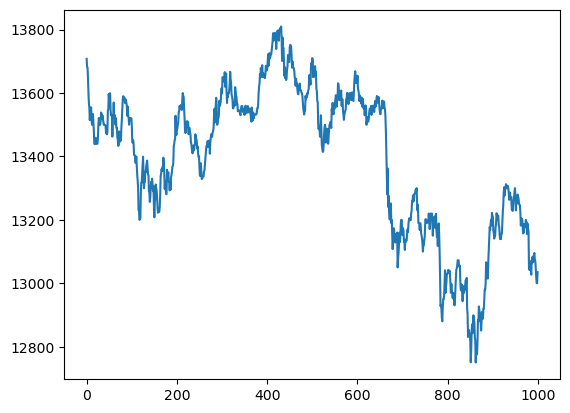

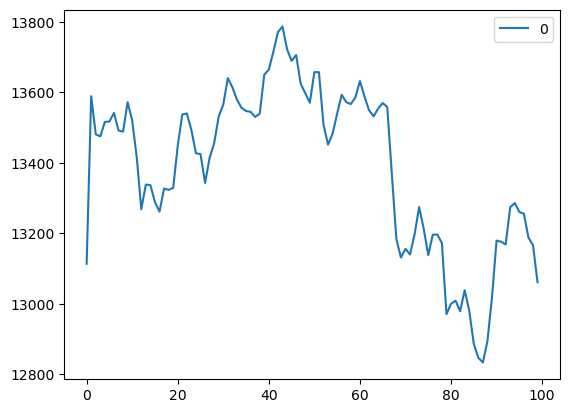

In [18]:
df["open"].iloc[:1000].plot()
pd.DataFrame(y_simplified).plot()

In [19]:
# This is interesting... but what if we do something slightly different?
# Maybe at every n data points, we instead save how much it went down compared to the previous data point?
# Generate the new set of values

y_temp = df["open"].iloc[:10000].to_numpy()
y_simplified = []

n = 10
previousValue = df["open"].iloc[0]
valueToAppend = 0
currentValue = 0

for i in range(0, int(len(y_temp)/n)) :
    counter = i*n
    
    for j in range (0, n) :
        currentValue = currentValue + int(y_temp[(i*n)-j])
    currentValue = currentValue/n
    
    # Find how much it changed by
    valueToAppend = currentValue - previousValue
    
    # Change the previousValue
    previousValue = currentValue
    
    y_simplified.append(valueToAppend)

<AxesSubplot:>

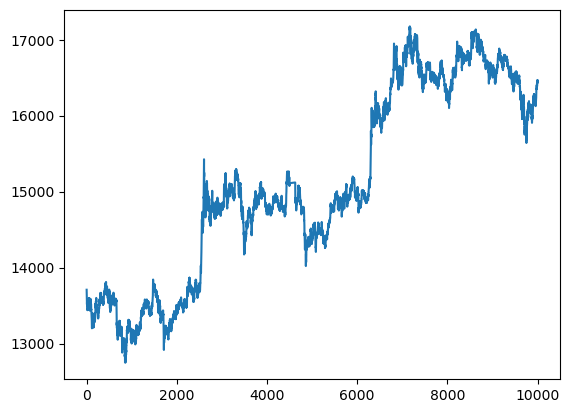

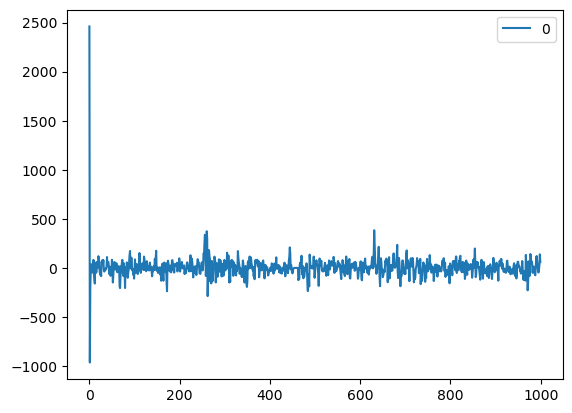

In [20]:
df["open"].iloc[:10000].plot()
pd.DataFrame(y_simplified).plot()

This seems like something we can work with better. However, the first 3 data points seem a bit inaccurate... not sure whats happening, so let's drop them

<AxesSubplot:>

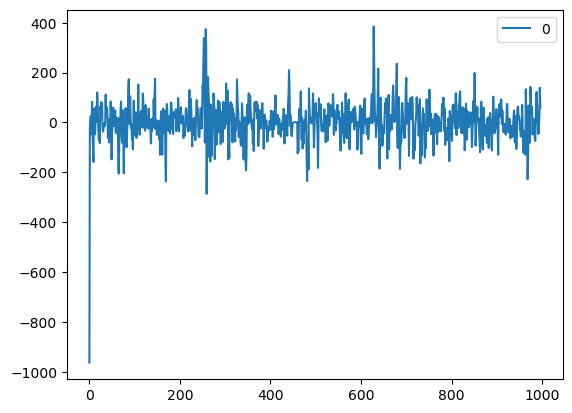

In [21]:
# Drop the first few values
y_simplified.pop(0)
y_simplified.pop(1)
y_simplified.pop(2)
pd.DataFrame(y_simplified).plot()

In [22]:
# Next, we need to train the model on this data. First, we setup the dataframe
simplified_data = pd.DataFrame()
simplified_data["y"] = y_simplified
simplified_data.head()

,y
0,-962.480000
1,-26.244800
2,4.937552
3,24.993755
4,-47.500624


## Train model on new data

In [23]:
# Set up test datasets
# Do a train/test split
test_percent = 0.05
# Get the entries we want
test_point = np.round(len(simplified_data)*test_percent)
test_ind = int(len(simplified_data) - test_point)
train = simplified_data.iloc[:test_ind]
test = simplified_data.iloc[test_ind:]

In [24]:
# Set up the scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [25]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 49
batch_size = 4

generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [26]:
# Create model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Model features
n_features = 1

# Define model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(length, n_features)))

# Compile model
model.compile(optimizer="adam", loss="mse")

In [27]:
# Train
model.fit_generator(generator, epochs=5)

Epoch 1/5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


225/225 [==============================] - 3s 11ms/step - loss: 0.0703
Epoch 2/5
225/225 [==============================] - 2s 11ms/step - loss: 0.0045
Epoch 3/5
225/225 [==============================] - 2s 11ms/step - loss: 0.0036
Epoch 4/5
225/225 [==============================] - 2s 11ms/step - loss: 0.0033
Epoch 5/5
225/225 [==============================] - 2s 11ms/step - loss: 0.0029


<AxesSubplot:>

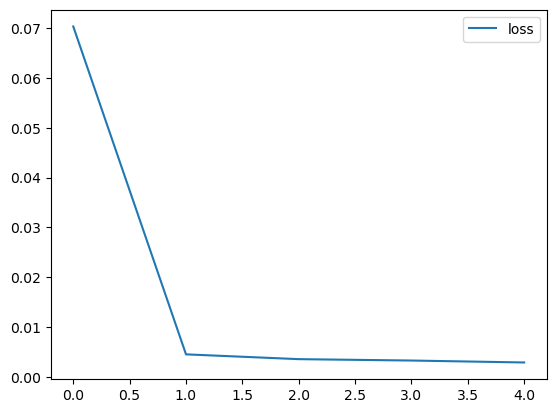

In [28]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [29]:
# 500, len = 10
# 10, 490 removed

first_eval_batch = scaled_train[-length:]

# Reshape it to the shape the model expects
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

pred = model.predict(first_eval_batch)
transformed = scaler.inverse_transform(pred)

1/1 [==============================] - 0s 134ms/step


In [30]:
""""# Initialise values
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
print (len(current_batch))
print (len(first_eval_batch))

# Make a for look the keeps appending the predictions
# predict value, add to array, move the historical values array by one place
for i in range(len(test)) :
    # Get the current predictions
    print (i)
    current_pred = model.predict(current_batch)[0]
    print(len(current_pred))
    # Append it to the list
    test_predictions.append(current_pred)
    # Move the current batch along by one timestamp, and add current pred at the end
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)"""

'"# Initialise values\ntest_predictions = []\nfirst_eval_batch = scaled_train[-length:]\ncurrent_batch = first_eval_batch.reshape((1, length, n_features))\nprint (len(current_batch))\nprint (len(first_eval_batch))\n\n# Make a for look the keeps appending the predictions\n# predict value, add to array, move the historical values array by one place\nfor i in range(len(test)) :\n    # Get the current predictions\n    print (i)\n    current_pred = model.predict(current_batch)[0]\n    print(len(current_pred))\n    # Append it to the list\n    test_predictions.append(current_pred)\n    # Move the current batch along by one timestamp, and add current pred at the end\n    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)'